# In order to get this milestone to work, the images from the Flickr-8k dataset should be placed in a directory called "Images" in the Milestone_4 directory.

# Part 1, Projection head

In [144]:
import torch

import gensim.downloader

glove_vectors = gensim.downloader.load('glove-twitter-200')
glove_vectors.most_similar('capitalism')

[('socialism', 0.8253527879714966),
 ('communism', 0.7220152020454407),
 ('democracy', 0.6800484657287598),
 ('capitalist', 0.6743904948234558),
 ('crony', 0.6574956774711609),
 ('fascism', 0.6154928803443909),
 ('ideology', 0.6098697185516357),
 ('imperialism', 0.6093625426292419),
 ('marxism', 0.5975797772407532),
 ('poverty', 0.5796671509742737)]

In [145]:
print(len(glove_vectors["capitalism"]))

200


In [146]:
captions = open("captions.txt", "r")
caption_lines = captions.readlines()
captions.close()

torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])
torch.Size([3, 200, 200])


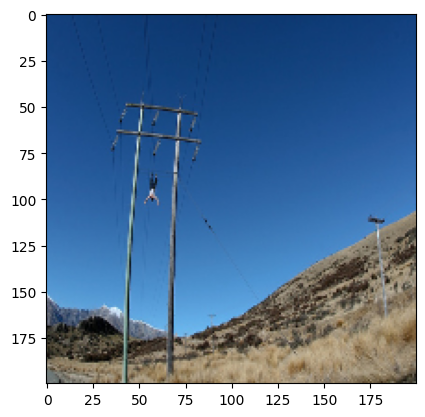

In [147]:
import random
import torchvision
from matplotlib import pyplot as plt
for i in range(10):
    image_path = "Images/" + random.choice(caption_lines).split(",")[0]
    image = torchvision.io.read_image(image_path)
    transform = torchvision.transforms.Resize([200, 200])
    image = transform(image)
    print(image.size())
    plt.imshow(image.permute(1, 2, 0))


In [148]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.compress = torch.nn.Sequential(
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
            torch.nn.Conv2d(3, 3, 3, stride=2, padding=1), #Compress by 4x
            torch.nn.ReLU(False),
        )
        self.decompress = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False),
            torch.nn.ConvTranspose2d(3, 3, 3, padding=1, stride=2, output_padding=1), #Decompress by 4x
            torch.nn.ReLU(False)
        )
         
    #We will train the network to predict its own input by compressing and then decompressing it
    def forward(self, input):
        return self.decompress(self.compress(input))

In [152]:
cnn = CNN()

gpu = torch.device('cuda') 
cnn.to(gpu)

adam = torch.optim.Adam(cnn.parameters(), lr=0.0001)
loss_function = torch.nn.MSELoss()


i=0
while i < 8000:
    try:
        image_path = "Images/" + random.choice(caption_lines).split(",")[0]
        image = torchvision.io.read_image(image_path)
        image = image.float()
        image /= 256
        transform = torchvision.transforms.Resize([200, 200])
        frame = transform(image)
    except:
        continue

    frame = frame.to(gpu) #Put the frame into the GPU

    output = cnn(frame)
    loss = loss_function(output, frame)
    loss.backward()

    adam.step()
    adam.zero_grad()
    i += 1
    
torch.save(cnn.state_dict(), 'cnn.pth')


# Part 2, contrastive loss

In [153]:
import math
class CNN2(torch.nn.Module):
    def __init__(self):
        super(CNN2, self).__init__()
        self.project_image = torch.nn.Sequential(
            torch.nn.Flatten(1, -1),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
        self.project_text = torch.nn.Sequential(
            torch.nn.Linear(200, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875),
            torch.nn.ReLU(),
            torch.nn.Linear(1875, 1875)
        )
         
    #We will train the network to predict its own input by compressing and then decompressing it
    def forward(self, word_encodings, image_encodings):

        word_encodings = self.project_text(word_encodings)
        image_encodings = self.project_image(image_encodings)

        dot_similarity = torch.matmul(word_encodings, torch.transpose(image_encodings, -1, 0))
        return dot_similarity

# Part 3, train the model

In [154]:
cnn2 = CNN2()
cnn2.to(gpu)

loss_function = torch.nn.CrossEntropyLoss()
adam = torch.optim.Adam(cnn2.parameters(), lr=0.000001)
transform = torchvision.transforms.Resize([200, 200])


validation_captions = open("captions.txt", "r")
validation_caption_lines = validation_captions.readlines()
validation_captions.close()

def fetch_images(caption_lines, n):
    images = []
    j = 0
    while j < n:
        try: #Some lines contain invalid input to these functions. This is a lazy way of circumventing it
            randline = random.choice(caption_lines)
            image = "Images/" + randline.split(",")[0]
            image = transform(torchvision.io.read_image(image))
        except:
            continue
        image = image.float()
        image /= 256
        image = image.to(gpu)
        image = cnn.compress(image)
        images.append(image)
        j += 1
        
    images = torch.stack(images)
    images = images.to(gpu)
    
    return images

def fetch_captions(caption_lines, n):
    captions = []

    j = 0
    while j < n:
        try:
            randline = random.choice(caption_lines)
            caption = random.choice(randline.split(",")[1].split(" ")[:-1])
            if caption in glove_vectors:
                captions.append(torch.FloatTensor(glove_vectors[caption]))
                j += 1
        except:
            continue
    

    captions = torch.stack(captions)
    captions = captions.to(gpu)

    return captions


i = 0
training_losses = []
validation_losses = []
while i < 1000:
    images = fetch_images(caption_lines, 10)
    captions = fetch_captions(caption_lines, 10)

    predicted = cnn2.forward(captions, images)

    image_embeddings = cnn2.project_image(images)
    text_embeddings = cnn2.project_text(captions)
    images_similarity = torch.matmul(image_embeddings, torch.transpose(image_embeddings, -1, 0))
    text_similarity = torch.matmul(text_embeddings, torch.transpose(text_embeddings, -1, 0))


    targets = (images_similarity + text_similarity) / 2
    
    loss = loss_function(predicted, targets)

    loss.backward()
    
    adam.step()
    adam.zero_grad()

    images = fetch_images(validation_caption_lines, 10)
    captions = fetch_captions(validation_caption_lines, 10)

    image_embeddings = cnn2.project_image(images)
    text_embeddings = cnn2.project_text(captions)
    images_similarity = torch.matmul(image_embeddings, torch.transpose(image_embeddings, -1, 0))
    text_similarity = torch.matmul(text_embeddings, torch.transpose(text_embeddings, -1, 0))


    targets = (images_similarity + text_similarity) / 2
    
    validation_loss = loss_function(predicted, targets)

    training_losses.append(loss.item())
    validation_losses.append(validation_loss.item())

    i += 1



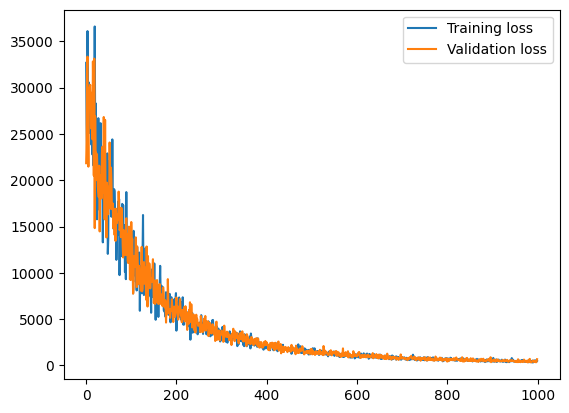

In [155]:
from matplotlib import pyplot as plt

plt.plot([i for i in range(len(training_losses))], training_losses, label="Training loss")
plt.plot([i for i in range(len(validation_losses))], validation_losses, label="Validation loss")
plt.legend()

plt.show()